In [1]:
import numpy as np 
import pandas as pd 
import csv
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
device = torch.device("mps")

In [3]:
# Geting training/validating dataset
x_train = []
x_label = []
val_train = []
val_label = []
raw_train = np.genfromtxt('train.csv', delimiter=',', dtype=str, skip_header=1)
for i in range(len(raw_train)):
    image = np.array(raw_train[i, 1].split(' ')).reshape(1, 48, 48)
    if (i % 10 == 0):
        val_train.append(image)
        val_label.append(raw_train[i][0])
    else:
        x_train.append(image)
        x_train.append(np.flip(image, axis=2))    # simple example of data augmentation
        x_label.append(raw_train[i][0])
        x_label.append(raw_train[i][0])
x_train = np.array(x_train, dtype=float) / 255.0
val_train = np.array(val_train, dtype=float) / 255.0
x_label = np.array(x_label, dtype=int)
val_label = np.array(val_label, dtype=int)

x_train = torch.FloatTensor(x_train)
val_train = torch.FloatTensor(val_train)
x_label = torch.LongTensor(x_label)
val_label = torch.LongTensor(val_label)
print(x_train.size(), val_train.size())

torch.Size([51676, 1, 48, 48]) torch.Size([2871, 1, 48, 48])


In [4]:
# Wrapped as dataloaders
train_set = TensorDataset(x_train, x_label)
val_set = TensorDataset(val_train, val_label)
batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=8)

In [5]:
def gaussian_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 and classname.find('Conv') == 0:
        m.weight.data.normal_(0.0, 0.02)

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),  # [64, 24, 24]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2, 0),      # [64, 12, 12]

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2, 0),      # [128, 6, 6]

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2, 0)       # [256, 3, 3]
        )

        self.fc = nn.Sequential(
            nn.Linear(256*3*3, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.5),
            nn.Linear(512, 7)
        )

        self.cnn.apply(gaussian_weights_init)
        self.fc.apply(gaussian_weights_init)

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)


In [7]:
model = Classifier().to(device)
print(model)

Classifier(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [8]:
# Set hyperparameters
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
best_acc = 0.0
num_epoch = 20

In [9]:
# Training
epoches = []
train_accs = []
val_accs = []


for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        train_pred = model(data[0].to(device))
        batch_loss = loss(train_pred, data[1].to(device))
        batch_loss.backward()
        optimizer.step()
        
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
        
        #Plot the progress
        progress = ('#' * int(float(i)/len(train_loader)*40)).ljust(40)
        print ('[%03d/%03d] %2.2f sec(s) | %s |' % (epoch+1, num_epoch, \
                (time.time() - epoch_start_time), progress), end='\r', flush=True)
    train_acc = train_acc/train_set.__len__()
    
    model.eval()
    for i, data in enumerate(val_loader):
        val_pred = model(data[0].to(device))
        batch_loss = loss(val_pred, data[1].to(device))

        val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        val_loss += batch_loss.item()

        progress = ('#' * int(float(i)/len(val_loader)*40)).ljust(40)
        print ('[%03d/%03d] %2.2f sec(s) | %s |' % (epoch+1, num_epoch, \
                (time.time() - epoch_start_time), progress), end='\r', flush=True)
        
    val_acc = val_acc/val_set.__len__()
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
        (epoch + 1, num_epoch, time.time()-epoch_start_time, \
        train_acc, train_loss, val_acc, val_loss))
    
    epoches.append(epoch)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    
    if (val_acc > best_acc):
        with open('save/acc.txt','w') as f:
            f.write(str(epoch)+'\t'+str(val_acc)+'\n')
        torch.save(model.state_dict(), 'save/model.pth')
        best_acc = val_acc
        print ('Model Saved!')

print("Finish Training!")    

[001/020] 28.07 sec(s) Train Acc: 0.212768 Loss: 959.312717 | Val Acc: 0.266458 loss: 21.469408
Model Saved!
[002/020] 26.29 sec(s) Train Acc: 0.253522 Loss: 369.705116 | Val Acc: 0.277604 loss: 21.427377
Model Saved!
[003/020] 27.32 sec(s) Train Acc: 0.260566 Loss: 363.872436 | Val Acc: 0.268896 loss: 21.203227
[004/020] 27.60 sec(s) Train Acc: 0.267261 Loss: 360.306606 | Val Acc: 0.301985 loss: 20.730779
Model Saved!
[005/020] 26.99 sec(s) Train Acc: 0.315117 Loss: 345.198192 | Val Acc: 0.363288 loss: 19.207945
Model Saved!
[006/020] 27.18 sec(s) Train Acc: 0.387046 Loss: 316.587205 | Val Acc: 0.399512 loss: 18.104679
Model Saved!
[007/020] 27.27 sec(s) Train Acc: 0.439063 Loss: 292.727431 | Val Acc: 0.453501 loss: 16.423494
Model Saved!
[008/020] 27.50 sec(s) Train Acc: 0.478094 Loss: 273.105697 | Val Acc: 0.490073 loss: 15.378089
Model Saved!
[009/020] 28.35 sec(s) Train Acc: 0.514204 Loss: 257.981432 | Val Acc: 0.539185 loss: 14.436148
Model Saved!
[010/020] 27.13 sec(s) Train Acc

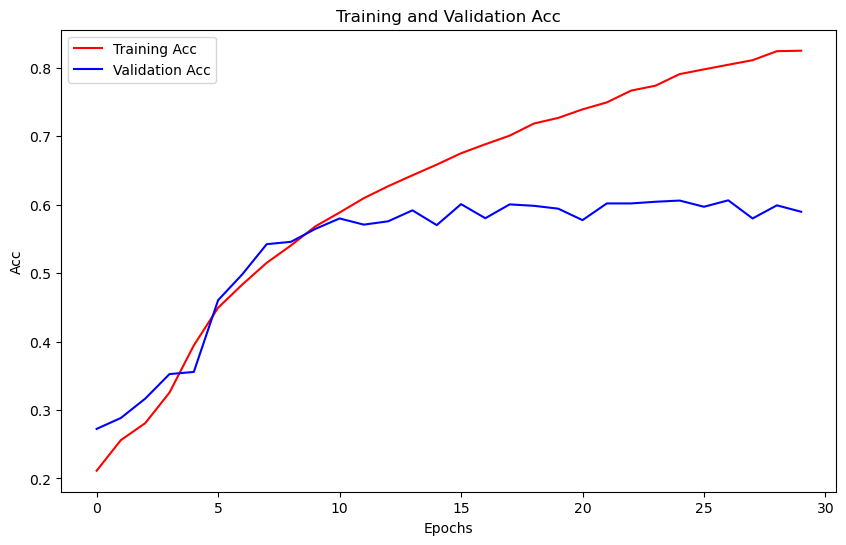

In [20]:
plt.figure(figsize=(10,6))
plt.plot(epoches, train_accs, 'r', label='Training Acc')
plt.plot(epoches, val_accs, 'b', label='Validation Acc')
plt.title('Training and Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [10]:
model = Classifier()
model.load_state_dict(torch.load('save/model.pth'))
model.to(device)

Classifier(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [8]:
x_test = []
raw_test = np.genfromtxt('test.csv', delimiter=',', dtype=str, skip_header=1)
for i in range(len(raw_test)):
    image = np.array(raw_test[i, 1].split(' ')).reshape(1, 48, 48)
    x_test.append(image)
x_test = np.array(x_test, dtype=float) / 255.0
x_test = torch.FloatTensor(x_test)
print(x_test.size())

torch.Size([7178, 1, 48, 48])


In [11]:
with torch.no_grad():
    test_pred = model(x_test.to(device))
    value, indices = torch.max(test_pred, dim = 1)
    print(indices)

tensor([3, 4, 3,  ..., 3, 0, 2], device='mps:0')


In [12]:
print(indices.size())

torch.Size([7178])


In [29]:
indices = indices.cpu().numpy()

df = pd.DataFrame({'id': range(len(indices)), 'label': indices})

df.to_csv('output.csv', index=False)

In [10]:
# Saliency Maps
def compute_saliency_maps(x, y, model):
    model.eval()
    x.requires_grad_()
    y_pred = model(x.to(device))
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_pred, y.to(device))
    loss.backward()

    saliency = x.grad.abs().squeeze().data
    return saliency

In [15]:
def show_saliency_maps(x, y, model):
    x_org = x.squeeze().numpy()
    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(x, y, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.detach().cpu().numpy()
    
    num_pics = x_org.shape[0]
    #for i in range(num_pics):
        # You need to save as the correct fig names
    #    plt.imsave('pic_'+ str(i), x_org[i], cmap=plt.cm.gray)
    #    plt.imsave('saliency_'+ str(i), saliency[i], cmap=plt.cm.jet)
    return saliency

In [24]:
saliency = compute_saliency_maps(x_train[0:10], x_label[0:10], model)

In [35]:
print(saliency[0][0])

[2.6088946e-03 1.8145187e-03 1.9454244e-03 1.1418359e-03 3.4049999e-03
 4.8108306e-03 5.7076341e-03 4.1601406e-03 3.3582901e-03 6.8094036e-05
 7.0381132e-03 2.7073704e-04 3.4913546e-03 2.3791196e-03 2.3192924e-03
 9.3899725e-04 2.4070125e-03 6.8524419e-03 8.5218195e-03 3.6327494e-03
 3.8063719e-03 2.4426787e-03 3.2573354e-03 1.5997717e-03 4.0188930e-03
 3.9450260e-04 2.3427668e-03 1.6990833e-03 5.9417939e-06 6.5740999e-03
 7.5514191e-03 9.7591486e-03 1.1225822e-02 3.8229886e-03 2.6936070e-03
 5.7214103e-04 8.2387608e-03 4.3206527e-03 2.9889597e-03 2.8490573e-03
 2.1394342e-03 7.3657464e-04 2.4057550e-03 4.2820731e-03 9.2168096e-03
 3.6361805e-04 3.5704579e-03 1.9574203e-03]


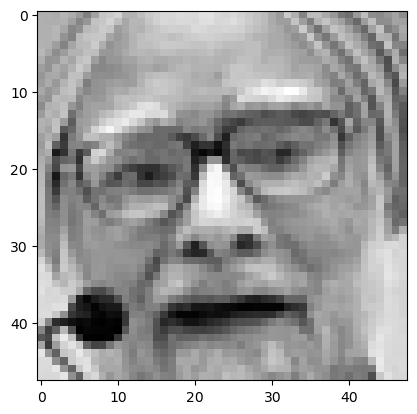

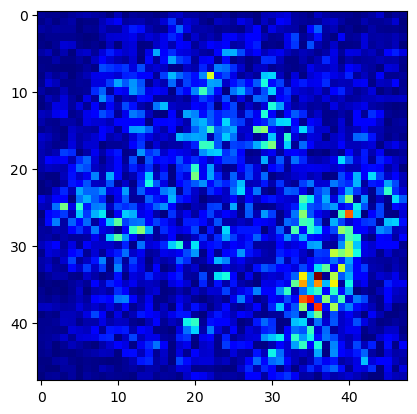

In [44]:
plt.imshow(x_train[0][0].numpy(), cmap = plt.cm.gray)
plt.show()
plt.imshow(saliency[0], cmap = plt.cm.jet)
plt.show()
#print(saliency)